<a href="https://colab.research.google.com/github/akkirajubhavana/SMAI_2024_ASSIGNMENTS/blob/main/SMAI_A1_Q1_KNN_DecisionTress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Decision Tree and KNN from scratch

In [ ]:
#imports
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

#Decision Tree - Classifier


In [ ]:
#Decision Tree
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [ ]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None, criterion='gini'):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None
        self.criterion = criterion

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self.grow_tree(X, y)

    def grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        if depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idx = np.random.choice(n_feats, self.n_features, replace=False)

        best_feature, best_threshold = self._best_split(X, y, feat_idx)

        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        left = self.grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self.grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)

        return Node(best_feature, best_threshold, left, right)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)

        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        # Check if the counter is empty
        if not counter:
            return -1  # or any other default value

        value = counter.most_common(1)[0][0]
        return value

    def _best_split(self, X, y, feat_idxs):
        if self.criterion == 'gini':
            return self._best_split_gini(X, y, feat_idxs)
        elif self.criterion == 'information_gain':
            return self._best_split_information_gain(X, y, feat_idxs)
        else:
            raise ValueError("Invalid criterion. Use 'gini' or 'information_gain'.")

    def _best_split_gini(self, X, y, feat_idxs):
        best_gain = float('inf')  # Initialize with infinity for Gini impurity
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the Gini impurity
                gain = self._gini_impurity(y, X_column, thr)

                if gain < best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    def _best_split_information_gain(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    def _gini_impurity(self, y, X_column, threshold):
        left_idx, right_idx = self._split(X_column, threshold)

        if len(left_idx) == 0 or len(right_idx) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idx), len(right_idx)
        p_l, p_r = n_l / n, n_r / n
        gini_l, gini_r = self._gini(y[left_idx]), self._gini(y[right_idx])

        gini_impurity = p_l * gini_l + p_r * gini_r

        return gini_impurity

    def _gini(self, y):
        hist = np.bincount(y)
        p = hist / len(y)
        gini = 1 - np.sum(p ** 2)

        return gini

    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idx, right_idx = self._split(X_column, threshold)

        if len(left_idx) == 0 or len(right_idx) == 0:
            return 0

        # calculate the weighted entropy of children
        n = len(y)
        n_l, n_r = len(left_idx), len(right_idx)
        e_l, e_r = self._entropy(y[left_idx]), self._entropy(y[right_idx])

        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy

        return information_gain

    def _entropy(self, y):
        hist = np.bincount(y)  # kind of histogram
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p > 0])

    def _split(self, X_column, split_thresh):
      left_idxs = np.argwhere(X_column <= split_thresh).flatten()
      right_idxs = np.argwhere(X_column > split_thresh).flatten()

      return left_idxs, right_idxs


    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy(y, y_pred)


#KNN classifier

In [ ]:
class KNN:
  def __init__(self, k,distance_metric,p=None):
    self.k = k
    self.distance_metric = distance_metric
    self.p = p


  def fit(self, X_train,y_train):
    self.X_train = X_train
    self.y_train = y_train

  def euclidean_distances(self,x_test):
    euc_distance = np.sqrt(np.sum((self.X_train - x_test)**2,axis =1))
    return euc_distance

  def manhattan_distance(self,x_test):
       man_distance = np.sum(np.abs(self.X_train -x_test),axis =1)
       return man_distance

  def cosine_distance(self,x_test):
   num = np.dot(self.X_train,x_test)
   xtrain_norm = np.sqrt(np.sum(self.X_train**2,axis = 1))
   xtest_norm = np.sqrt(np.sum(x_test**2))
   cos_sim = num / (xtrain_norm * xtest_norm)
   cos_sim = np.clip(cos_sim, -1.0, 1.0)
   cos_distance = 1 - cos_sim

   return cos_distance

  def minikowski_distance(self,x_test):
    if self.p is None:
        raise ValueError("Parameter 'p' must be provided for Minikowski distance.")

    min_distance = np.power(np.sum(np.power(np.abs(self.X_train - x_test), self.p), axis=1), 1/self.p)
    return min_distance
#modify this to switch
  def distance(self,x_test):
    if self.distance_metric == "euclidean":
      distances = self.euclidean_distances(x_test)
      return distances
    if self.distance_metric == "manhattan":
      distances = self.manhattan_distance(x_test)
      return distances
    if self.distance_metric == "cosine":
      distances = self.cosine_distance(x_test)
      return distances
    if self.distance_metric == "minikowski":
      distances = self.minikowski_distance(x_test)
      return distances
    else:
            print(f"Invalid distance metric: {self.distance_metric}")
            raise ValueError("Invalid distance metric")
    #return distances
  def __repr__(self):
        return f"KNN(k={self.k}, distance_metric={self.distance_metric})"

  def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)

  def _predict(self, x):
        distances = self.distance(x)
        k_neighbors_indices = np.argsort(distances)[:self.k]
        k_neighbor_labels = [self.y_train[i] for i in k_neighbors_indices]
        most_common = np.bincount(k_neighbor_labels).argmax()
        return most_common



#Data standardization and label encoding


In [ ]:
def standarization_encoder(X,y):
  # Normalize features
  scaler = MinMaxScaler()
  X_scaled = scaler.fit_transform(X)

  # Encode labels
  label_encoder = LabelEncoder()
  y_encoded = label_encoder.fit_transform(y)

  return X_scaled,y_encoded

#Accuracy function


In [ ]:
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

#Calling DecisionTree class


In [ ]:
#Defining variables
train_accuracy_dt=[]
test_accuracy_dt=[]

In [ ]:
def decision_tree(criterion,depth,X_train,X_test,y_train,y_test):
  clf = DecisionTree(criterion=criterion,max_depth=depth)
  clf.fit(X_train, y_train)
  y_train_pred = clf.predict(X_train)
  y_test_pred = clf.predict(X_test)

  # Calculate accuracy and append to the lists
  train_acc=accuracy_score(y_train, y_train_pred)
  test_acc = accuracy_score(y_test, y_test_pred)
  return train_acc,test_acc

#Calling KNN Classifier


#Train test split for KNN


In [ ]:
def trainTest_split(data_size,X_scaled,y_encoded):
  train_size = int(0.3 * data_size)
  test_size = int(0.1 * data_size)

  # Shuffle the indices of the dataset
  indices = np.random.permutation(data_size)

  # Use the first 30% for training
  train_indices = indices[:train_size]
  train_data = X_scaled[train_indices]
  train_labels = y_encoded[train_indices]

  # Use the next 10% for testing
  test_indices = indices[train_size:train_size + test_size]
  test_data = X_scaled[test_indices]
  test_labels = y_encoded[test_indices]

  return train_data,test_data,train_labels,test_labels

In [ ]:
def knnClassifier(k,distance_metric,train_data,test_data,train_labels,test_labels):
    knn_classifier = KNN(k=k, distance_metric= distance_metric)
    knn_classifier.fit(train_data, train_labels)

    # Predict on train and test sets
    y_train_pred = knn_classifier.predict(train_data)
    y_test_pred = knn_classifier.predict(test_data)

    # Calculate accuracy and append to the lists
    train_acc_values =(accuracy_score(train_labels, y_train_pred))
    test_acc_values= (accuracy_score(test_labels, y_test_pred))

    return train_acc_values,test_acc_values



#Data Loading

In [ ]:
import matplotlib.pyplot as plt

# Load data
file_path = '/content/Q1Data.csv'
data = pd.read_csv(file_path)

print(data.isnull().sum())


MFCCs_ 1    0
MFCCs_ 2    0
MFCCs_ 3    0
MFCCs_ 4    0
MFCCs_ 5    0
MFCCs_ 6    0
MFCCs_ 7    0
MFCCs_ 8    0
MFCCs_9     0
MFCCs_10    0
MFCCs_11    0
MFCCs_12    0
MFCCs_13    0
MFCCs_14    0
MFCCs_15    0
MFCCs_16    0
MFCCs_17    0
MFCCs_18    0
MFCCs_19    0
MFCCs_20    0
MFCCs_21    0
Family      0
Genus       0
Species     0
dtype: int64


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7195 entries, 0 to 7194
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MFCCs_ 1  7195 non-null   float64
 1   MFCCs_ 2  7195 non-null   float64
 2   MFCCs_ 3  7195 non-null   float64
 3   MFCCs_ 4  7195 non-null   float64
 4   MFCCs_ 5  7195 non-null   float64
 5   MFCCs_ 6  7195 non-null   float64
 6   MFCCs_ 7  7195 non-null   float64
 7   MFCCs_ 8  7195 non-null   float64
 8   MFCCs_9   7195 non-null   float64
 9   MFCCs_10  7195 non-null   float64
 10  MFCCs_11  7195 non-null   float64
 11  MFCCs_12  7195 non-null   float64
 12  MFCCs_13  7195 non-null   float64
 13  MFCCs_14  7195 non-null   float64
 14  MFCCs_15  7195 non-null   float64
 15  MFCCs_16  7195 non-null   float64
 16  MFCCs_17  7195 non-null   float64
 17  MFCCs_18  7195 non-null   float64
 18  MFCCs_19  7195 non-null   float64
 19  MFCCs_20  7195 non-null   float64
 20  MFCCs_21  7195 non-null   floa

In [ ]:
print(data.describe())

          MFCCs_ 1     MFCCs_ 2     MFCCs_ 3     MFCCs_ 4     MFCCs_ 5  \
count  7195.000000  7195.000000  7195.000000  7195.000000  7195.000000   
mean      0.323584     0.311224     0.445997     0.127046     0.097939   
std       0.218653     0.263527     0.160328     0.162722     0.120412   
min      -0.673025    -0.436028    -0.472676    -0.636012    -0.410417   
25%       0.165945     0.138445     0.336737     0.051717     0.012581   
50%       0.302184     0.274626     0.481463     0.161361     0.072079   
75%       0.466566     0.430695     0.559861     0.222592     0.175957   
max       1.000000     1.000000     1.000000     0.752246     0.964240   

          MFCCs_ 6     MFCCs_ 7     MFCCs_ 8      MFCCs_9     MFCCs_10  ...  \
count  7195.000000  7195.000000  7195.000000  7195.000000  7195.000000  ...   
mean     -0.001397    -0.000370     0.128213     0.055998    -0.115682  ...   
std       0.171404     0.116302     0.179008     0.127099     0.186792  ...   
min      -0.53898

In [ ]:
[print(data[columns].shape) for columns in data.columns]
print(data.shape)



(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195,)
(7195, 24)


#Extract features and labels for KNN for Decision Tree

In [ ]:
#Decision Tree
X_dt = data.iloc[:, :6]
y_dt = data['Genus']
print(X_dt.shape)

(7195, 6)


# Extract features and labels for KNN

In [ ]:
X_Knn = data.iloc[:, :21].values
y_knn = data['Genus'].values
print(X_Knn)

[[ 1.52936298e-01 -1.05585903e-01  2.00721915e-01 ...  5.76839750e-02
   1.18680135e-01  1.40384460e-02]
 [ 1.71534257e-01 -9.89747370e-02  2.68425221e-01 ...  2.01399630e-02
   8.22629870e-02  2.90557420e-02]
 [ 1.52317085e-01 -8.29726740e-02  2.87127957e-01 ... -2.50832270e-02
   9.91084000e-02  7.71623850e-02]
 ...
 [-5.82556781e-01 -3.43237394e-01  2.94678470e-02 ...  2.78338000e-02
  -5.30615000e-04 -8.04253340e-02]
 [-5.19497158e-01 -3.07553060e-01 -4.92150000e-03 ...  4.18033790e-02
  -2.79113830e-02 -9.68953700e-02]
 [-5.08833178e-01 -3.24105837e-01  6.20676240e-02 ...  3.15595730e-02
  -2.93554760e-02 -8.79096250e-02]]


In [ ]:
classifier= input("Enter the classifier:")
if classifier == "KNN":
  X = X_Knn
  y = y_knn
else :
  X = X_dt
  y = y_dt


Enter the classifier:KNN


In [ ]:
X_scaled,y_encoded = standarization_encoder(X,y)

#Decision Tree


In [ ]:
#Decision Tree
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.8, random_state=42)

In [ ]:
# Initialize lists to store accuracy and depth values
depths = list(range(1, 16))
train_accuracy_dt=[]
test_accuracy_dt=[]

In [ ]:
criteria = input("Enter criteria : information_gain or gini: ")
for depth in range(1, 16):
  train_acc,test_acc = decision_tree(criterion = criteria,depth=depth,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
  train_accuracy_dt.append(train_acc)
  test_accuracy_dt.append(test_acc)

Enter criteria : information_gain or gini: information_gain


In [ ]:
#Information Gain
for depth, train_acc, test_acc in zip(range(1, 16), train_accuracy_dt, test_accuracy_dt):
  print(f"Tree Depth {depth}: Train Accuracy = {train_acc:.4f}, Test Accuracy = {test_acc:.4f}")

Tree Depth 1: Train Accuracy = 0.6956, Test Accuracy = 0.6793
Tree Depth 2: Train Accuracy = 0.7790, Test Accuracy = 0.7629
Tree Depth 3: Train Accuracy = 0.8721, Test Accuracy = 0.8549
Tree Depth 4: Train Accuracy = 0.9076, Test Accuracy = 0.8831
Tree Depth 5: Train Accuracy = 0.9388, Test Accuracy = 0.9025
Tree Depth 6: Train Accuracy = 0.9694, Test Accuracy = 0.9013
Tree Depth 7: Train Accuracy = 0.9896, Test Accuracy = 0.9213
Tree Depth 8: Train Accuracy = 0.9979, Test Accuracy = 0.9218
Tree Depth 9: Train Accuracy = 1.0000, Test Accuracy = 0.9194
Tree Depth 10: Train Accuracy = 1.0000, Test Accuracy = 0.9192
Tree Depth 11: Train Accuracy = 1.0000, Test Accuracy = 0.9152
Tree Depth 12: Train Accuracy = 1.0000, Test Accuracy = 0.9187
Tree Depth 13: Train Accuracy = 1.0000, Test Accuracy = 0.9222
Tree Depth 14: Train Accuracy = 1.0000, Test Accuracy = 0.9196
Tree Depth 15: Train Accuracy = 1.0000, Test Accuracy = 0.9147


In [ ]:
#Gini
for depth, train_acc, test_acc in zip(range(1, 16), train_accuracy_dt, test_accuracy_dt):
  print(f"Tree Depth {depth}: Train Accuracy = {train_acc:.4f}, Test Accuracy = {test_acc:.4f}")

Tree Depth 1: Train Accuracy = 0.5664, Test Accuracy = 0.5792
Tree Depth 2: Train Accuracy = 0.5664, Test Accuracy = 0.5777
Tree Depth 3: Train Accuracy = 0.5664, Test Accuracy = 0.5785
Tree Depth 4: Train Accuracy = 0.5664, Test Accuracy = 0.5780
Tree Depth 5: Train Accuracy = 0.5664, Test Accuracy = 0.5785
Tree Depth 6: Train Accuracy = 0.5664, Test Accuracy = 0.5785
Tree Depth 7: Train Accuracy = 0.5664, Test Accuracy = 0.5784
Tree Depth 8: Train Accuracy = 0.5664, Test Accuracy = 0.5787
Tree Depth 9: Train Accuracy = 0.5664, Test Accuracy = 0.5785
Tree Depth 10: Train Accuracy = 0.5664, Test Accuracy = 0.5773
Tree Depth 11: Train Accuracy = 0.5664, Test Accuracy = 0.5785
Tree Depth 12: Train Accuracy = 0.5664, Test Accuracy = 0.5780
Tree Depth 13: Train Accuracy = 0.5664, Test Accuracy = 0.5778
Tree Depth 14: Train Accuracy = 0.5664, Test Accuracy = 0.5773
Tree Depth 15: Train Accuracy = 0.5664, Test Accuracy = 0.5784


15


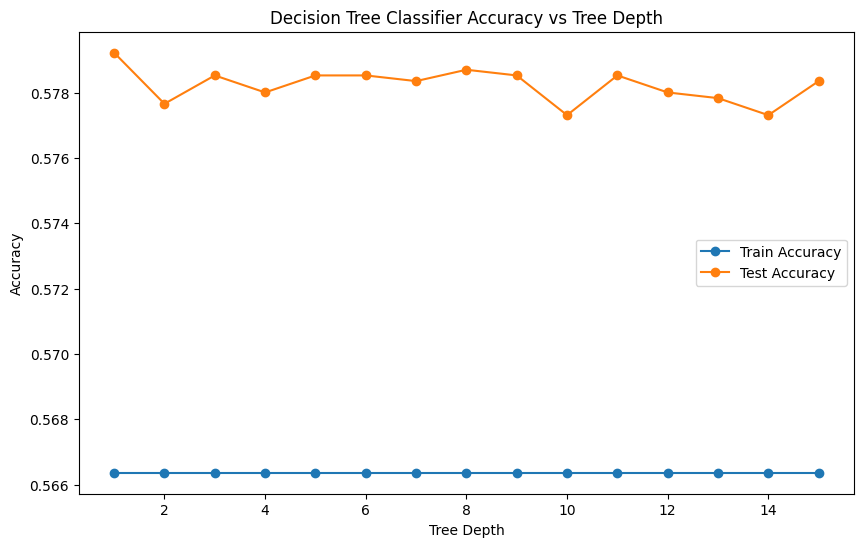

In [ ]:
# Plot the accuracy vs tree depth
print(len(train_accuracy_dt))
plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), train_accuracy_dt, label='Train Accuracy', marker='o')
plt.plot(range(1, 16), test_accuracy_dt, label='Test Accuracy', marker='o')
plt.title('Decision Tree Classifier Accuracy vs Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

15


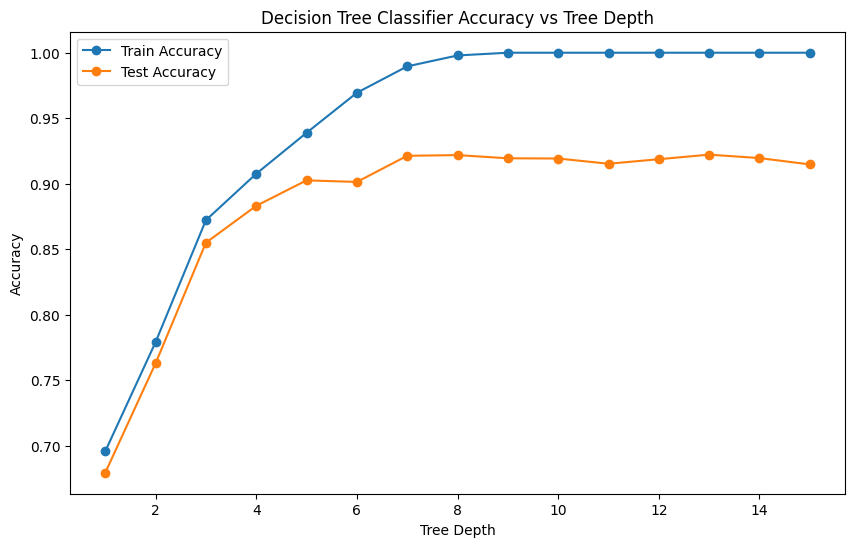

In [ ]:
# Plot the accuracy vs tree depth - information gain
print(len(train_accuracy_dt))
plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), train_accuracy_dt, label='Train Accuracy', marker='o')
plt.plot(range(1, 16), test_accuracy_dt, label='Test Accuracy', marker='o')
plt.title('Decision Tree Classifier Accuracy vs Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print("Max Train Accuracy:" ,max(train_accuracy_dt))

print("Max Testing Accuracy: ", max(test_accuracy_dt))

Max Train Accuracy: 0.56636553161918
Max Testing Accuracy:  0.579221681723419


#Observation from Decision Tree
* Maximum Test accuracy of Decision Tree that built from scratch is 92.4%  using information gain as impurity metrics

* Maximum Test accuracy of Decision Tree that built from scratch is 57.9% using gini index as impurity metrics

* Comparing Test accuracy and Train accuracy We have more accuracy in training data .
* Till particular point of k , the accuracy got increased after that it remained constant

#KNN

In [ ]:
data_size = len(data)
print(data_size)

7195


In [ ]:
X_train,X_test,y_train,y_test = trainTest_split(data_size,X_scaled,y_encoded)

In [ ]:
metric = input("Enter the distance metric - euclidean,cosine,manhattan,minikowski: ")

Enter the distance metric - euclidean,cosine,manhattan,minikowski: cosine


In [ ]:

k_values = list(range(1, 51))
train_acc_values = []
test_acc_values = []
for k in range(1, 51):
    knn_train_acc, knn_test_acc = knnClassifier(k,metric,X_train,X_test,y_train,y_test)
    train_acc_values.append(knn_train_acc)
    test_acc_values.append(knn_test_acc)
for k, train_acc, test_acc in zip(range(1,51), train_acc_values, test_acc_values):
    print(f"KNN k={k}: Train Accuracy = {train_acc:.4f}, Test Accuracy = {test_acc:.4f}")

KNN k=1: Train Accuracy = 1.0000, Test Accuracy = 0.9764
KNN k=2: Train Accuracy = 0.9917, Test Accuracy = 0.9791
KNN k=3: Train Accuracy = 0.9903, Test Accuracy = 0.9777
KNN k=4: Train Accuracy = 0.9838, Test Accuracy = 0.9708
KNN k=5: Train Accuracy = 0.9838, Test Accuracy = 0.9694
KNN k=6: Train Accuracy = 0.9796, Test Accuracy = 0.9666
KNN k=7: Train Accuracy = 0.9805, Test Accuracy = 0.9652
KNN k=8: Train Accuracy = 0.9727, Test Accuracy = 0.9638
KNN k=9: Train Accuracy = 0.9699, Test Accuracy = 0.9638
KNN k=10: Train Accuracy = 0.9662, Test Accuracy = 0.9583
KNN k=11: Train Accuracy = 0.9666, Test Accuracy = 0.9597
KNN k=12: Train Accuracy = 0.9639, Test Accuracy = 0.9555
KNN k=13: Train Accuracy = 0.9625, Test Accuracy = 0.9541
KNN k=14: Train Accuracy = 0.9606, Test Accuracy = 0.9555
KNN k=15: Train Accuracy = 0.9606, Test Accuracy = 0.9499
KNN k=16: Train Accuracy = 0.9574, Test Accuracy = 0.9499
KNN k=17: Train Accuracy = 0.9564, Test Accuracy = 0.9485
KNN k=18: Train Accurac

In [ ]:
# Initialize kNN classifier

# knn_classifier = KNN(k=7, distance_metric="euclidean")
# accuracies =[]
# k_values = list(range(1, 51))
# for k in k_values:
#     knn_classifier.k = k
#     knn_classifier.fit(train_data, train_labels)
#     y_pred = knn_classifier.predict(test_data)
#     accuracy = accuracy_score(test_labels, y_pred)
#     accuracies.append(accuracy)

K_values: 1, Test Accuracy: 0.9763560500695411
K_values: 2, Test Accuracy: 0.9791376912378303
K_values: 3, Test Accuracy: 0.9777468706536857
K_values: 4, Test Accuracy: 0.9707927677329624
K_values: 5, Test Accuracy: 0.9694019471488178
K_values: 6, Test Accuracy: 0.9666203059805285
K_values: 7, Test Accuracy: 0.9652294853963839
K_values: 8, Test Accuracy: 0.9638386648122392
K_values: 9, Test Accuracy: 0.9638386648122392
K_values: 10, Test Accuracy: 0.9582753824756607
K_values: 11, Test Accuracy: 0.9596662030598053
K_values: 12, Test Accuracy: 0.9554937413073713
K_values: 13, Test Accuracy: 0.9541029207232267
K_values: 14, Test Accuracy: 0.9554937413073713
K_values: 15, Test Accuracy: 0.9499304589707928
K_values: 16, Test Accuracy: 0.9499304589707928
K_values: 17, Test Accuracy: 0.9485396383866481
K_values: 18, Test Accuracy: 0.9499304589707928
K_values: 19, Test Accuracy: 0.9499304589707928
K_values: 20, Test Accuracy: 0.9471488178025035
K_values: 21, Test Accuracy: 0.9471488178025035
K

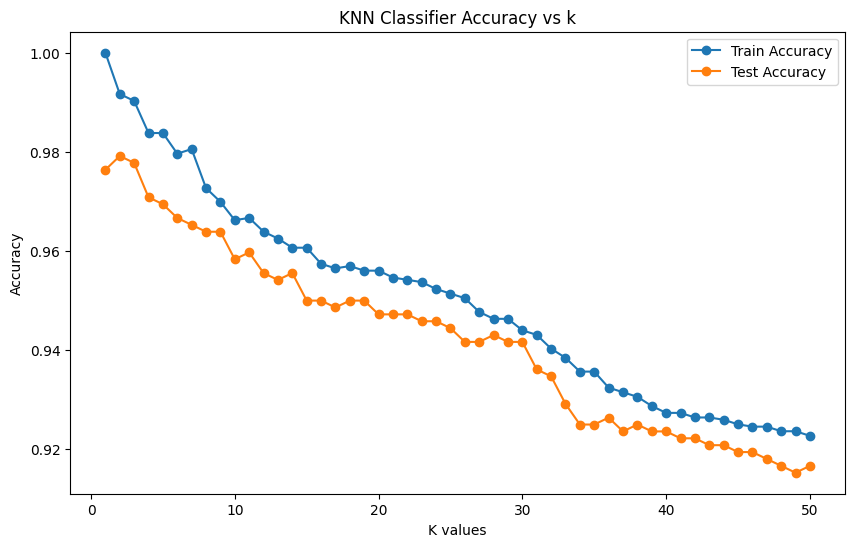

In [ ]:
# Print the test accuracies for each depth
for k, accuracy in zip(k_values, test_acc_values):
    print(f"K_values: {k}, Test Accuracy: {accuracy}")



# Plot the accuracy vs tree depth
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), train_acc_values, label='Train Accuracy', marker='o')
plt.plot(range(1, 51), test_acc_values, label='Test Accuracy', marker='o')
plt.title('KNN Classifier Accuracy vs k')
plt.xlabel('K values')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
max_accuracy = 0
max_accuracy= max(test_acc_values)
max_accuracy_train = max(train_acc_values)
print(max_accuracy_train)
best_k = k_values[test_acc_values.index(max_accuracy)]
print(f"Maximum Test Accuracy: {max_accuracy:.4f} achieved with k = {best_k}")

1.0
Maximum Test Accuracy: 0.9791 achieved with k = 2


**Observation from KNN:**

*   Maximum Test accuracy of KNN that built from scratch is 98.7% which is achieved at k=1.using euclidean as distance metrics
* Maximum Test Accuracy: 0.9819 achieved with k = 1 using Manhattan as distance metrics
* Maximum Test Accuracy: 0.9791 achieved with k = 2 using Cosine as distance
metrics
* As k value increases the accuracy got decreasing.
* Among three metrics, with euclidean distance we got higher accuracy compared with other distance metrics.




#SKLEARN

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Assuming X and y are your features and labels

# Decision Tree
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:


tree_accuracies = []
depths_sklearn = range(1, 16)

for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    tree_accuracies.append(accuracy)




In [ ]:
# k Nearest Neighbours
knn_accuracies = []
k_values_sklearn = range(1, 1001)

for k in k_values_sklearn:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    knn_accuracies.append(accuracy)

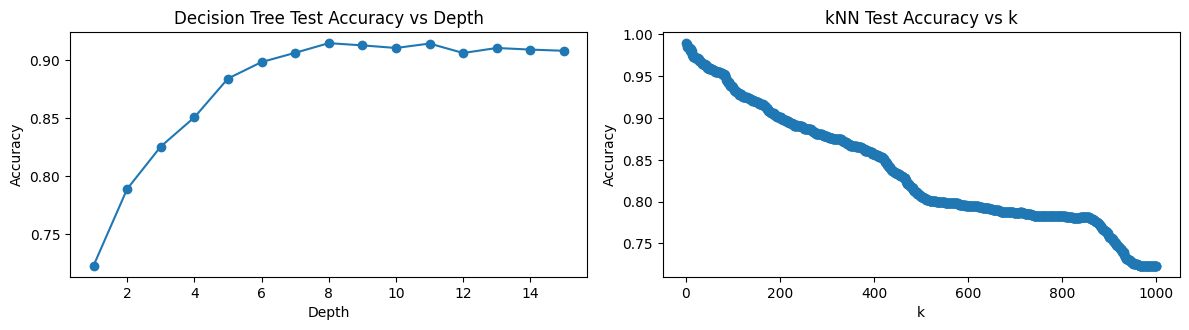

In [ ]:
import matplotlib.pyplot as plt

# Plotting Decision Tree accuracies
plt.figure(figsize=(12, 6))


plt.subplot(2, 2, 1)
plt.plot(depths, tree_accuracies, marker='o')
plt.title('Decision Tree Test Accuracy vs Depth')
plt.xlabel('Depth')
plt.ylabel('Accuracy')

# Plotting k Nearest Neighbours accuracies
plt.subplot(2, 2, 2)
plt.plot(k_values_sklearn, knn_accuracies, marker='o')
plt.title('kNN Test Accuracy vs k')
plt.xlabel('k')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

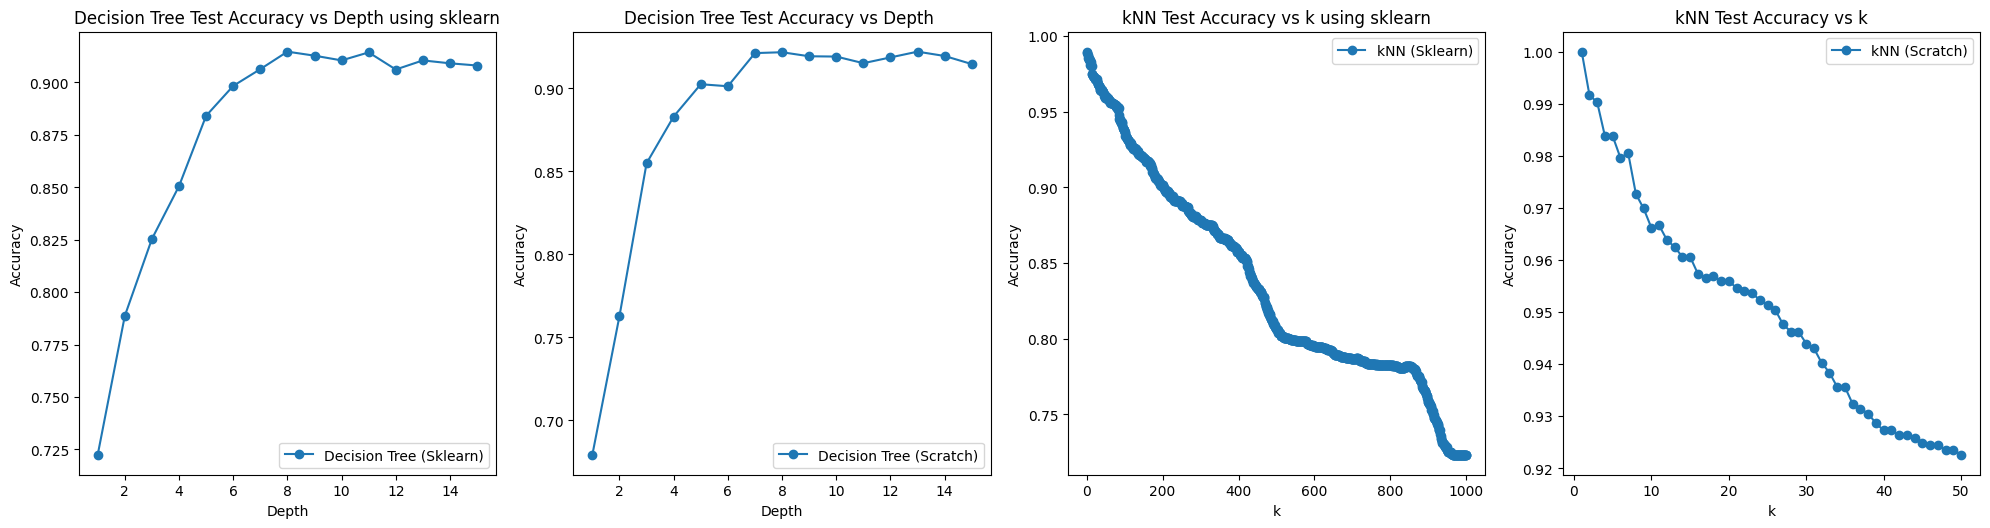

In [ ]:


plt.figure(figsize= (20, 20))
plt.subplot(4, 4, 1)
plt.plot(depths_sklearn, tree_accuracies, marker='o', label='Decision Tree (Sklearn)')
plt.title('Decision Tree Test Accuracy vs Depth using sklearn')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(4, 4, 2)
plt.plot(depths, test_accuracy_dt, marker='o', label='Decision Tree (Scratch)')
plt.title('Decision Tree Test Accuracy vs Depth ')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(4, 4, 3)
plt.plot(k_values_sklearn, knn_accuracies, marker='o', label='kNN (Sklearn)')
plt.title('kNN Test Accuracy vs k using sklearn')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(4, 4, 4)
plt.plot(range(1,51), train_acc_values, marker='o', label='kNN (Scratch)')
plt.title('kNN Test Accuracy vs k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:

print("Max accuracy of KNN using Sklearn:", max(knn_accuracies))

print("Max accuracy of KNN from scratch:", max(knn_test_acc))



Max accuracy of KNN using Sklearn: 0.9895760945100764
Max accuracy of KNN from scratch: 0.9847009735744089


In [ ]:
print("Max accuracy of Decision Tree using Sklearn:", max(tree_accuracies))

print("Max accuracy of Decision Tree from scratch:", max(tree_accuracies))

Max accuracy of Decision Tree using Sklearn: 0.9146977067407922
Max accuracy of Decision Tree from scratch: 0.9244266851980542


**Observations**

| Model                       | Scikit-Learn Accuracy | Scratch Implementation Accuracy |
|-----------------------------|-----------------------|----------------------------------|
| Decision Tree               | 0.9147                | 0.9244                           |
| k Nearest Neighbours (kNN)  | 0.9896                | 0.9847                           |

This table shows the maximum accuracy achieved by each model using Scikit-Learn and the scratch implementation.
* In Decision Tree, Implementation from scratch gave us more accuracy than with scikit
* In KNN, Scikit Learn gave us more accuracy.
* Comparatively Scikit-Learn is faster than the scratch implementation.